<a href="https://colab.research.google.com/github/arpithaupd/ai4covid/blob/master/covid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we demonstrate how to train a convolutional network, that has been pretrained on a large dataset of X-Rays, on a much smaller target dataset containing X-rays of patients affected by several lung diseases, including the COVID-19. Our task is to predict whether a patient is affected by COVID-19 or not, based on an X-ray image. For this task we will use the publicly available [covid-chestxray-dataset](https://github.com/ieee8023/covid-chestxray-dataset/).

Due to the small amount of training data in our dataset, we will use a pretrained network to initialize the weights of our model, which should increase the accuracy, since the model will already be capable of extracting higher-level features from X-ray images, thus won't have to learn it from scratch. This approach is called transfer learning and is extensively used in computer vision. The pretrained network is a DenseNet121 trained on the CheXpert dataset, which contains over 200,000 labeled chest radiographs. The network was trained to detect presence of 14 observations in radiology reports [[arXiv:1901.07031]](https://arxiv.org/pdf/1901.07031.pdf).


In [ ]:
!python --version

Python 3.6.9


In [1]:
# download covid-chestxray-datase
!wget --quiet --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1o_0SBhUPGCqLTWiGwMbHBMP12YK6EIMo' -O /content/covid-chest-xray.zip
!unzip -qq /content/covid-chest-xray.zip

warning [/content/covid-chest-xray.zip]:  358029 extra bytes at beginning or within zipfile
  (attempting to process anyway)


In [2]:
# download the model pretrained on the CheXpert dataset
!wget --quiet --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1MgmUWiSu_LsmDlOZ1EXKllcqRGZWUsRr' -O /content/pretrained_CheXNet.pth.tar

In [3]:
from os.path import join as pjoin

import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from sklearn.metrics import f1_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt

If a GPU card is available, it will be used for training and evaluation

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using {device}')

Using cuda:0


First, we define the architecture and initialize the weights. Next, we load the weights of the pretrained model. Finally, we replace the last layer (i.e. the classification layer) to match our desired output dimension which is 1 (patient has COVID-19 or not).

In [5]:
class COVID19Classifier(nn.Module):
  def __init__(self, model_fn):
    super().__init__()
    self.model = model_fn(pretrained=False)
    self.pool = nn.AdaptiveAvgPool2d(1)
    self.num_features = self.model.classifier.in_features
    self.model.classifier = nn.Linear(self.num_features, 42)
  
  def forward(self, x):
    x = self.model.features(x)
    x = F.relu(x, inplace=True)
    x = self.pool(x).view(x.size(0), -1)
    x = self.model.classifier(x)
    x = torch.sigmoid(x)
    return x

In [6]:
# initialize model
model = COVID19Classifier(torchvision.models.densenet121)

In [7]:
# load pretrained weights
ckpt_dict = torch.load('/content/pretrained_CheXNet.pth.tar')
model_state = {k[7:]: v for k, v in ckpt_dict['model_state'].items()}
model.load_state_dict(model_state)

<All keys matched successfully>

In [8]:
# replace the classification layer
model.model.classifier = nn.Linear(model.num_features, 1)
# place model on the target device
model = model.to(device)

Now, we define data loaders which will supply our network with data during training. The data loader reads images from the dataset directory and transforms them to match the dimensions and pixel distribution of the input. Additionally, we add a simple data augmentation transformation, in order to artificially increase the size of the dataset used for training.

In [9]:
class COVID19DataSet(Dataset):
    def __init__(self, metadata, image_dir, transform=None):
      self.image_names = image_dir + metadata.filename.values
      self.labels = metadata.has_covid19.values
      self.transform = transform

    def __getitem__(self, index):
        image_name = self.image_names[index]
        image = Image.open(image_name).convert('RGB')
        label = self.labels[index]
        if self.transform is not None:
            image = self.transform(image)
        return image, torch.FloatTensor([label])

    def __len__(self):
        return len(self.image_names)

In [10]:
# define transformation applied to train images
train_transform = transforms.Compose([
  transforms.Resize(320),
  transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# define transformation applied to validation images
# note, that all transformations which apply random effects are removed
val_transform = transforms.Compose([
  transforms.Resize(224),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])            
])

Here, we load the metadata file with information about the X-ray images, including the label, and divide the dataset into train and validation. Since we are interested in detecting only COVID-19, we simply label all patients with COVID-19 as 1 and all other patients as 0. Finally we intialize the dataloaders for both train and validation

In [11]:
image_dir = '/content/images/'
metadata_file = '/content/metadata.csv'

metadata = pd.read_csv(metadata_file)
metadata['has_covid19'] = metadata.finding == 'COVID-19'
metadata_train, metadata_val = train_test_split(
    metadata, test_size=0.2, stratify=metadata.finding, random_state=12345)

train = COVID19DataSet(metadata_train, image_dir, transform=train_transform)
train = DataLoader(dataset=train, batch_size=10, shuffle=True, num_workers=1)

val = COVID19DataSet(metadata_val, image_dir, transform=val_transform)
val = DataLoader(dataset=val, batch_size=len(val), num_workers=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  del sys.path[0]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


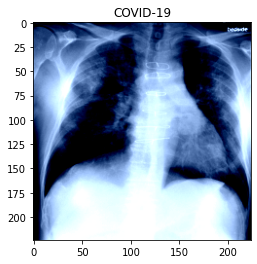

In [12]:
x_batch, y_batch = next(iter(val))
image = x_batch[0].numpy()
has_covid19 = y_batch[0].item()
plt.title('COVID-19' if has_covid19 else 'Other disease')
plt.imshow(image.transpose((1, 2, 0)))

Below, we implement methods for training and evaluating the network. There is a standard training loop which implements the forward and backward pass for each batch in the data loader, and stores the best model based on the f1 score on the validation set. We choose f1 score as the target metric as opposed to e.g. accuracy, because the dataset is highly imbalanced.

In [13]:
def fit(model, epochs, ckpt_path=None):
    optimizer = optim.Adam(model.parameters(), weight_decay=1e-4)
    loss_fn = torch.nn.BCELoss()
    best_val_f1 = 0.
    for epoch in range(0, epochs):
        train_loss = train_epoch(train, model, optimizer, loss_fn)
        val_y_true, val_y_pred = predict(val, model)
        val_y_pred = val_y_pred > 0.5
        val_f1 = f1_score(val_y_true.numpy(), val_y_pred.numpy())
        print(f'Epoch {epoch + 1} train_loss={train_loss:.3f} val_f1={val_f1:.3f}')
        if ckpt_path is not None and val_f1 > best_val_f1:
          torch.save({'state_dict': model.state_dict()}, ckpt_path)
          best_val_f1 = val_f1
  
def train_epoch(data_loader, model, optimizer, loss_fn):
    model.train()
    train_loss = 0.
    for x, y_true in data_loader:
        x = x.to(device)
        y_true = y_true.to(device)      
        y_pred = model(x)
        loss = loss_fn(y_pred, y_true)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= math.ceil(len(data_loader) / data_loader.batch_size)
    return train_loss

def predict(data_loader, model):
  model.eval()
  y_true = torch.FloatTensor()
  y_pred = torch.FloatTensor()
  with torch.no_grad():
    for batch_x, batch_y in data_loader:
      batch_x = batch_x.to(device)
      batch_y_pred = model(batch_x).cpu()
      y_true = torch.cat([y_true, batch_y])
      y_pred = torch.cat([y_pred, batch_y_pred])
  return y_true, y_pred

def validate_model(data_loader, model, optimizer, loss_fn):
    model.eval()
    val_loss = 0.
    with torch.no_grad():
        for x, y_true in data_loader:
            x = x.to(device)
            y_true = y_true.to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y_true)
            val_loss += loss.item()
    val_loss /= math.ceil(len(data_loader) / data_loader.batch_size)
    return val_loss

We train our network for 5 epochs. Since the dataset is so small and the network so deep, we don't want to train for too long to avoid overfitting.

In [14]:
fit(model, epochs=5, ckpt_path='model.pth.tar')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  del sys.path[0]


Epoch 1 train_loss=2.078 val_f1=0.909


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  del sys.path[0]


Epoch 2 train_loss=2.353 val_f1=0.909


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  del sys.path[0]


Epoch 3 train_loss=2.101 val_f1=0.923


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  del sys.path[0]


Epoch 4 train_loss=1.650 val_f1=0.857


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  del sys.path[0]


Epoch 5 train_loss=2.058 val_f1=0.909


Once the network is trained, we load the weights from checkpoint where the model achieved highest validation score. Then we plot the ROC which helps us choose a threshold for the presence of COVID-19. Choosing the right threshold below which we classify patient as not a COVID-19 patient is essential. We want to make sure, that the patients with COVID-19 will not be misclassified, so we should choose a very rigorous threshold. Specifically, we are interested in a threshold which results in the lowest `false positive rate` while maintaining a high `true positive rate` ([https://en.wikipedia.org/wiki/Sensitivity_and_specificity](https://en.wikipedia.org/wiki/Sensitivity_and_specificity)).

Actual=1.0 Predicted=0.897 Filename=covid-19-pneumonia-15-PA.jpg
Actual=1.0 Predicted=1.000 Filename=1-s2.0-S0929664620300449-gr3_lrg-c.jpg
Actual=0.0 Predicted=0.074 Filename=SARS-10.1148rg.242035193-g04mr34g05x-Fig5-day9.jpeg
Actual=1.0 Predicted=1.000 Filename=7E335538-2F86-424E-A0AB-6397783A38D0.jpeg
Actual=1.0 Predicted=0.972 Filename=6A7D4110-2BFC-4D9A-A2D6-E9226D91D25A.jpeg
Actual=0.0 Predicted=0.963 Filename=F051E018-DAD1-4506-AD43-BE4CA29E960B.jpeg
Actual=1.0 Predicted=1.000 Filename=covid-19-pneumonia-12.jpg
Actual=1.0 Predicted=0.987 Filename=covid-19-pneumonia-14-PA.png
Actual=1.0 Predicted=0.982 Filename=171CB377-62FF-4B76-906C-F3787A01CB2E.jpeg
Actual=0.0 Predicted=0.836 Filename=SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day12.jpeg
Actual=1.0 Predicted=0.889 Filename=7EF28E12-F628-4BEC-A8C5-E6277C2E4F60.png
Actual=1.0 Predicted=0.998 Filename=jkms-35-e79-g001-l-b.jpg
Actual=1.0 Predicted=0.896 Filename=kjr-21-e24-g003-l-b.jpg
Actual=1.0 Predicted=0.976 Filename=auntminni

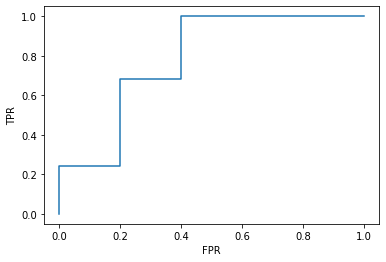

In [ ]:
ckpt_dict = torch.load('/content/model.pth.tar')
model.load_state_dict(ckpt_dict['state_dict'])
y_true, y_pred = predict(val, model)
for i in range(len(y_true)):
  filename = metadata_val.iloc[i].filename
  actual = y_true[i].item()
  predicted = y_pred[i].item()
  print(f'Actual={actual} Predicted={predicted:.3f} Filename={filename}')
fpr, tpr, thresholds = roc_curve(y_true.numpy(), y_pred.numpy())
auc_score = auc(fpr, tpr)
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()